## Roman Planet Search Pipeline Notebook

Download "bls_cuda"  
`git clone https://github.com/jasonfrowe/bls_cuda`  
make a note of where you installed bls_cuda.

You may find it useful to create a virtual environment for this workbook (optional)

`python -m venv bls_env`         # Install create virtual environment that we will name 'bls_env'   
`source ./bls_env/bin/activate`  # Active the new environment  
`pip install ipykernel`          # Install iPython kernel  
`python -m ipykernel install --user --name=bls_env`  # Add Kernel to Jupyter  
(now make sure you have selected `bls_env` as your active Kernel for this notebook)

Package requirements:
- numpy
- matplotlib
- tqdm
- numba
- scipy
- astroquery
- exotic_ld (optional, but useful for transit modelling)
- setuptools (needed for exotic_ld)

`pip install numpy matplotlib tqdm numba scipy astroquery setuptools`

It is also recommended to install ipywidgets for Jupyter notebooks    
`pip install ipywidgets`

If you want to use exotic_ld you can download the atmosphere library (8.5G):  
`wget https://kona.ubishops.ca/roman/exotic_ld_data.tgz`  
then uncompress it  
`tar -zxf exotic_ld_data.tgz`  
which will create a folder called `exotic_ld_data` that is referenced below.  
Next, install exotic_ld  
`pip install exotic_ld`

## Leo Vetter 

`git clone https://github.com/mkunimoto/LEO-vetter.git`  
`cd LEO-vetter`  
`pip install .`  
`pip install pandas`  LEO requires Pandas



## Required Libraries for the Transit search

In [1]:
import os, sys
sys.path.append(os.path.abspath("./bls_cuda"))  #Make sure this path points to where you installed bls_cuda.

import importlib.util #To check if certain libraries are available 

import numpy as np

from astropy.io import fits

import bls_cpu as gbls     #BLS routines that run on the CPU
import transitPy5 as tpy5  #Transit modelling module 

import matplotlib.pyplot as plt  #MatPlotLib for some simple plots 

# for BLS routine
import transitPy5 as tpy5        # routines to handle transit photometry
import bls_cpu as gbls           # BLS CPU implementation 

# Set the  file and stellar information

We are applying the transit search, modeling and flux vetting routines to a simulated light curve which includes a transiting planet with a 21.649717 day period.

In [2]:
## Set inputs of the tpy5_inputs_class
tpy5_inputs = tpy5.tpy5_inputs_class() #This sets up parameters for data processing

## Star ID
tpy5_inputs.roi   = 232842  #Roman ID
tpy5_inputs.mstar =    0.77
tpy5_inputs.rstar =    0.72
tpy5_inputs.teff  = 5346.0 
tpy5_inputs.logg  =    4.61 
tpy5_inputs.feh   =   -0.643
## and assign stellar errors (Assuming 20% errors for this example)
tpy5_inputs.e_mstar = 0.2 * tpy5_inputs.mstar
tpy5_inputs.e_rstar = 0.2 * tpy5_inputs.rstar
tpy5_inputs.e_logg =  0.2 * tpy5_inputs.logg
tpy5_inputs.e_teff =  0.2 * tpy5_inputs.teff
tpy5_inputs.e_metal = 0.2 * tpy5_inputs.feh

tpy5_inputs.photfile = 'TRExS_232842_F146_simlc.fits'  # File used in this example
tpy5_inputs.photdir  = './'                            # Location of example photometry

## Routine for reading in the FITS file

In [3]:
def read_roman_phot(tpy5_inputs):
    """ Routine for reading in Roman data from FITS files
    """

    phot = tpy5.phot_class()
    fits_fname = tpy5_inputs.photdir + "/" + tpy5_inputs.photfile

    # Open up the FITS files and 
    hdu=fits.open(fits_fname)

    lc_time=hdu[1].data['TIME']
    flux=hdu[1].data['FLUX']
    ferr=hdu[1].data['FLUX_ERR']
    int_time=hdu[0].header['EXPOSURE'] + np.zeros(len(lc_time))
    qflag=hdu[1].data['QUALITY']

    hdu.close()

    # Sort the data by time-stamps (in case it's not already) 
    si=np.argsort(lc_time)

    # go through the data and get rid of NaNs, Infs and other trash
    # Identify the indices where there are NaNs in array_with_nan
    nan_indices = np.isnan(flux)

    phot.time  = lc_time[si][~nan_indices] - tpy5_inputs.rjd
    phot.flux  = flux[si][~nan_indices]
    phot.ferr  = ferr[si][~nan_indices]
    phot.itime = int_time[si][~nan_indices]/86400.0 # Convert from seconds to days 
    phot.qflag = qflag[si][~nan_indices]

    phot.tflag = np.zeros(len(phot.time))  # Flag for in-transit data
    phot.icut  = np.zeros(len(phot.time))  # Flag for data cuts 
    phot.flux_f = np.copy(phot.flux)       # Space to store processed data

    phot.tflag = np.zeros((phot.time.shape[0])) # pre-populate array to mark transit data (=1 when in transit)

    # Normalize photometry
    fmean = np.median(phot.flux)
    phot.flux = phot.flux / fmean
    phot.ferr = phot.ferr / fmean
    
    return phot

## Read in the photometry

In [4]:
# Read in the photometry 

# Data is stored in a class:

# phot.time   - time stamps
# phot.flux   - normalized raw photometry 
# phot.flux_f - normalized processed photometry (this is what we search and model, is initialized as a copy of phot.flux)
# phot.ferr   - photometry error
# phot.itime  - integration time (used with the transit model)
# phot.qflag  - quality flags
# phot.tflag  - marks in transit data (initialized to 0 for no-transit)
# phot.icut   - flags data to be ignored for transit search and transit modelling (initialized to zero)

phot146 = read_roman_phot(tpy5_inputs)

## Quick plot of raw photometry

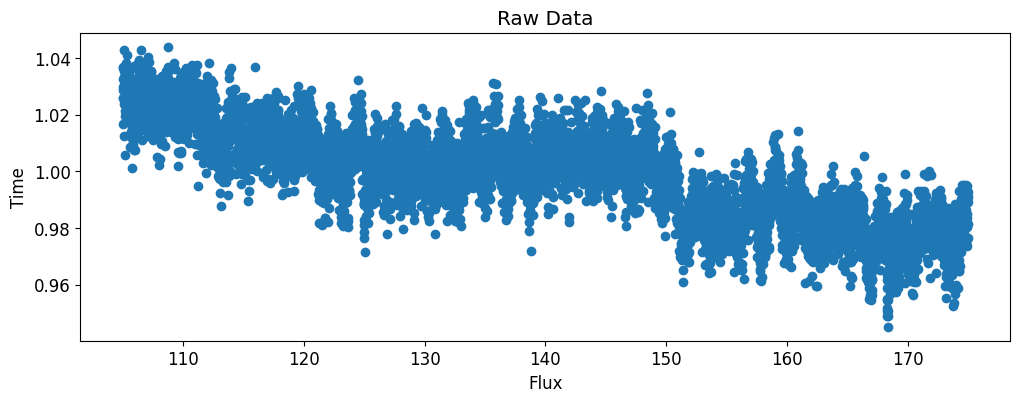

In [5]:
# Raw Light curve 
fig=plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 12})
plt.scatter(phot146.time,phot146.flux)
plt.title('Raw Data')
plt.ylabel('Time')
plt.xlabel('Flux')
plt.show()

# Run data processing

Data conditioning for the transit search includes:
- applying a data filter
- rejecting outliers


In [6]:
# Run the detrending 
tpy5.run_polyfilter(phot146, tpy5_inputs)  # flux_f will contain the filtered photometry

In [7]:
# Outlier rejection
tpy5.run_cutoutliers(phot146, tpy5_inputs) # data clipping, phot.icut will flag bad data

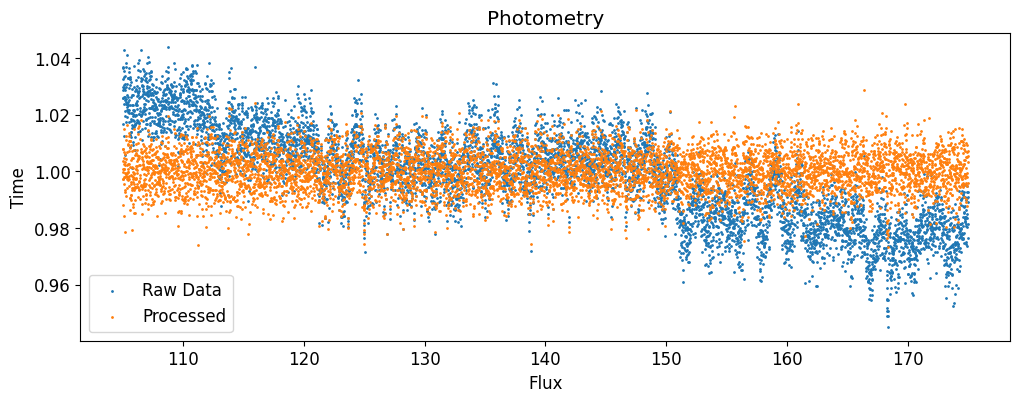

In [8]:
# Plot the detrended Light curve 
fig=plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 12})
plt.scatter(phot146.time,phot146.flux, label = 'Raw Data', s = 1)
plt.scatter(phot146.time[(phot146.icut == 0)], phot146.flux_f[(phot146.icut == 0)], label = 'Processed', s =1)
plt.title('Photometry')
plt.ylabel('Time')
plt.xlabel('Flux')
plt.legend()
plt.show()

# Run BLS Search

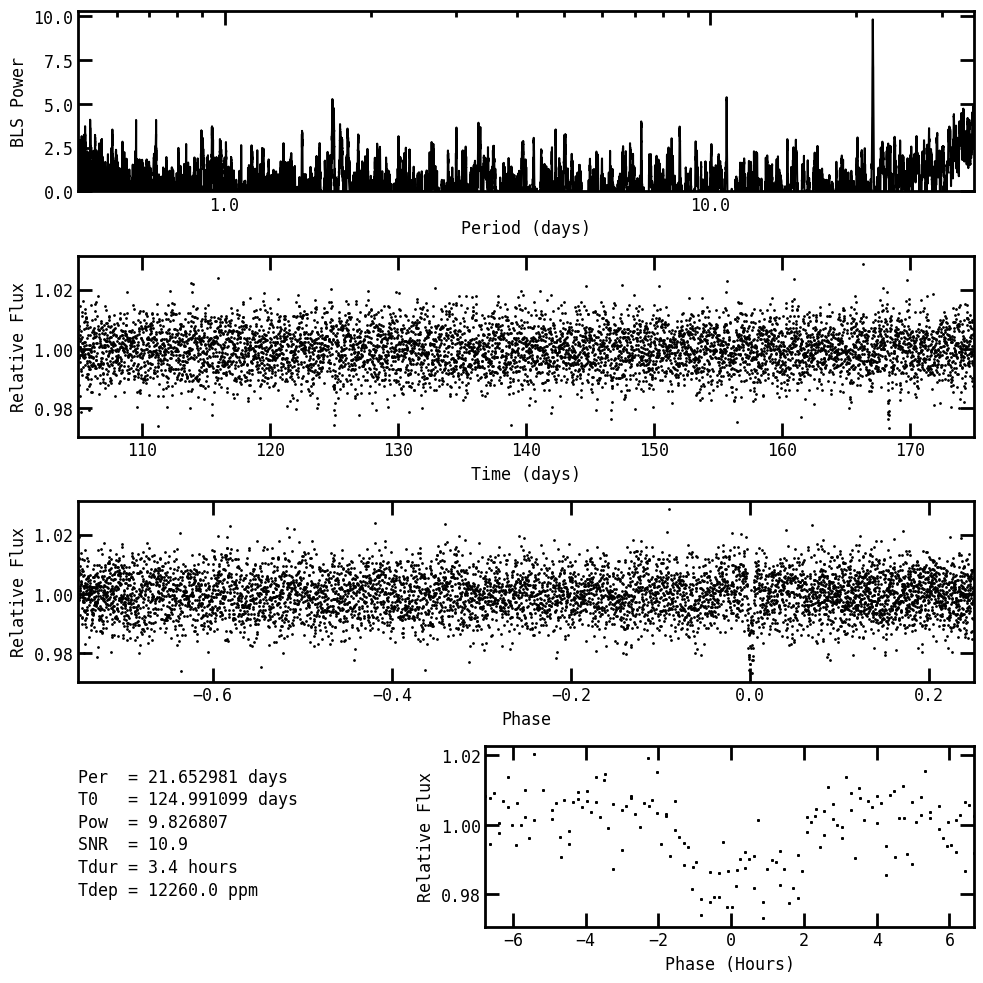

In [9]:
# Set up the BLS inputs and run
gbls_inputs          = gbls.gbls_inputs_class() # Initialize needed inputs
gbls_inputs.zerotime = 0.0
gbls_inputs.Rstar    = tpy5_inputs.mstar
gbls_inputs.Mstar    = tpy5_inputs.rstar
gbls_inputs.plots    = 1 # 1=X11, 2=both, 0=none
gbls_inputs.freq1    = 2/(np.max(phot146.time) - np.min(phot146.time))
gbls_inputs.freq2    = -1 # default value of 0.5 day period
gbls_inputs.filename = tpy5_inputs.photfile  # Used for naming the file, extension replaced with PNG.

# Run BLS, applying data cuts
gbls_ans = gbls.bls(gbls_inputs, phot146.time[(phot146.icut == 0)], phot146.flux_f[(phot146.icut == 0)])

In [10]:
# Event Parameters from BLS

# gbls_ans class contains output from BLS search:
    
print("Period:", gbls_ans.bper, "T0:", gbls_ans.epo)
print("Tdur:", gbls_ans.tdur)
print("Tdepth:", gbls_ans.depth)
print("S/N:", gbls_ans.snr)

Period: 21.652981032403222 T0: 124.99109944678092
Tdur: 0.14074437671062093
Tdepth: 0.012260049137579722
S/N: 10.90854145549521


# Model Fitting 

Uses the Kepler `transitfit5` module that has been updated for Python/Numba with optimized performance.


In [11]:
import utils_python.transitmodel as transitm
import utils_python.keplerian as kep
import utils_python.transitfit as transitf
import utils_python.transitplot as transitp

#Check for exotic_ld, not available we just use solar values for now.
if importlib.util.find_spec("special_package"):
    from exotic_ld import StellarLimbDarkening
    use_exotic_ld = 1
else:
    use_exotic_ld = 0

In [12]:
# Create an initial guess for all 18 parameters
sol     = transitm.transit_model_class() # Single planet model has up-to 18-model parameters

# Parameters that define the star/scene for the transit model
sol.rho = kep.rhostar(gbls_ans.bper, gbls_ans.tdur)    # Guess for mean stellar density based on transit-duration and period (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening 
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = 0.0    # Photometric zero point

# Set up Limb-darkening (q1, q2 parameterization)
if use_exotic_ld == 1:
    ld_data_path = './exotic_ld_data/'  #location of exotic spectral library 
    ld_model = 'mps1'
    sld = StellarLimbDarkening(M_H, teff, logg, ld_model, ld_data_path)
    ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
    sol.nl3 = ld[0]
    sol.nl4 = ld[1]
else:
    sol.nl3 = 0.311 #Solar values for TESS
    sol.nl4 = 0.270 

#The parameters below are stored as arrays, as the model is multi-planet ready.
sol.t0  = [gbls_ans.epo]             # Center of transit time (days)
sol.per = [gbls_ans.bper]            # Orbital Period (days)
sol.bb  = [0.5]                      # Impact parameter
sol.rdr = [np.sqrt(gbls_ans.depth)]  # Rp/R*
sol.ecw = [0.0]                      # sqrt(e)cos(w)
sol.esw = [0.0]                      # sqrt(e)sin(w)
sol.krv = [0.0]                      # RV amplitude (m/s)
sol.ted = [0.0]                      # thermal eclipse depth (ppm)
sol.ell = [0.0]                      # Ellipsodial variations (ppm)
sol.alb = [0.0]                      # Albedo amplitude (ppm)
sol.npl = 1                          # Number of planets

In [13]:
# Mark in-transit data.  Since BLS will likely underestimate the transit-duration, we will pad to be safe.
kep.mark_intransit_data(phot146, sol, tdurcut = 1.0)  # tdurcut is the amount of +/- time to protect centred on the transit 
tpy5.run_polyfilter(phot146, tpy5_inputs)         # Re-apply detrending to protect the transit event from distortion

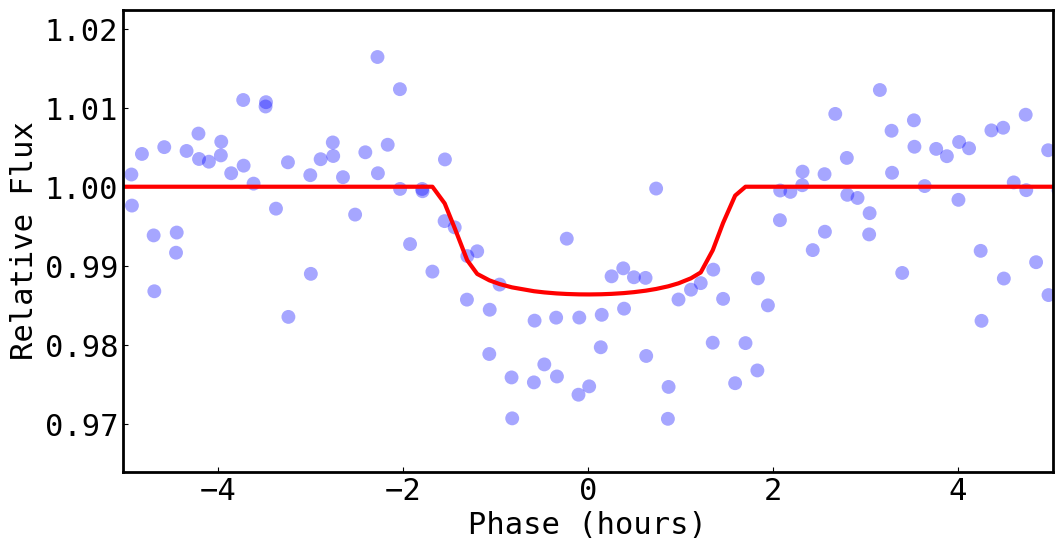

In [14]:
# Plot the initial model and data


#### This might not be using the processed data, also need to make sure that the outliers are removed
transitp.plotTransit(phot146, sol)

In [15]:
# Define the parameters to fit
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]


# Fit the data (note, only data with tflag = 1 is used in the model fit, so we increase the amount of data protected to get a good out-of-transit baseline
kep.mark_intransit_data(phot146, sol, tdurcut = 2.0)
sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot146)

In [16]:
# See the fitted parameter (Note the error is a simple co-variance matrix at this stage)
transitp.printParams(sol_fit)

ρ* (g/cm³):                     4.1997208 ± 4.6286201
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                                 0.311 ± 0.0
q2:                                  0.27 ± 0.0
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         3.743e-04 ± 6.644e-04
t0 (days):                     125.0047922 ± 0.0041547
Period (days):                 21.6525897 ± 0.0032040
Impact parameter:               0.0991252 ± 3.6899300
Rp/R*:                          0.1272936 ± 0.0098227
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


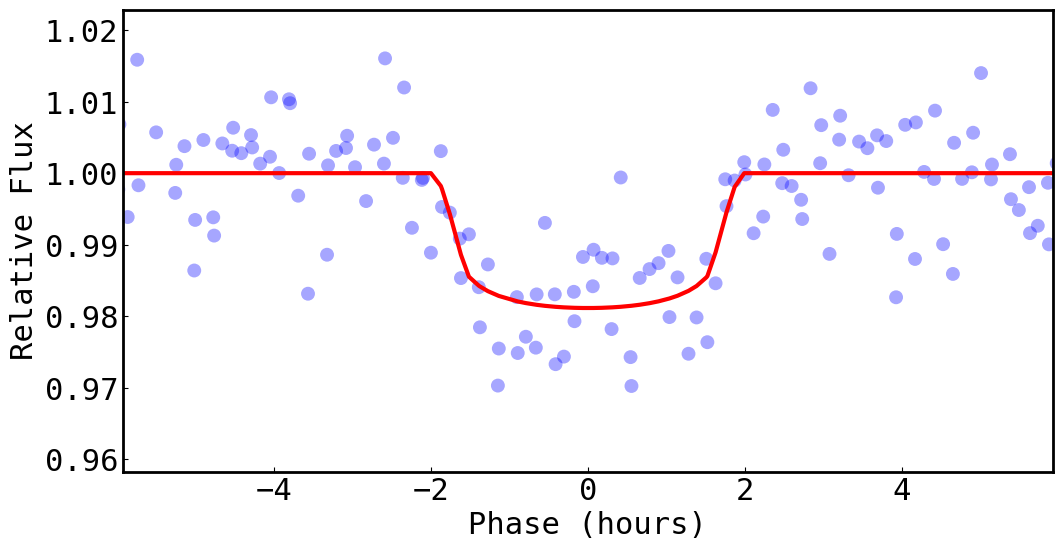

In [17]:
# Plot the optimized model and data
transitp.plotTransit(phot146, sol_fit)

# MCMC Module

We can now use MCMC to model the event and estimate posteriors.  MCMC is based on de-MCMC.

Please note that running the MCMC module takes a variety of time depending on the type of computer used to run the worksheet (Xeon processors tend to be slow). It is safe to skip down to the LEO flux vetting section. 

In [21]:
import utils_python.transitmcmc as tmcmc
import utils_python.mcmcroutines as mcmc

In [23]:
nsteps1           = 10000 # total length of chain will be nwalkers*nsteps
nsteps2           = 50000 # nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc        = 50000 # If MCMC did not converge we make a longer chain.  
burninf           = 0.5   # burn-in for evalulating convergence (conservative value picked -- 0.2 to 0.3 is probably fine) 
niter_cor         = 5000  # Used for generating buffer
burnin_cor        = 1000  # How much of initial buffer to toss 
nthin             = 101   # thinning data when generating statistics (keep every nth value)
nloopmax          = 5     # Maximum loops to reach convergence.  If you hit the max without convergence increase nsteps2 and nsteps_inc 
converge_crit     = 1.02  # Convergence criteria (Gelman-Rubin PSRF)
buf_converge_crit = 1.2   # Convergence criteria for buffer -- for generating deMCMC buffer

# Making sure data is normalized near 1
if np.rint(np.median(phot146.flux)) != 1:  
    raise ValueError

# Generate input for mcmc
lnprob, x, beta = tmcmc.genmcmcInput(sol_fit, params_to_fit)
sol_a = sol_fit.to_array()
serr = sol_fit.err_to_array()

params = [nsteps1, nsteps2, nsteps_inc, burninf, niter_cor, burnin_cor, nthin, nloopmax, converge_crit, buf_converge_crit]

## Run MCMC

In [25]:
# Takes about 100s on our test system.
chain, accept, burnin = tmcmc.demcmcRoutine(x, beta, phot146, sol_a, serr, params, lnprob)

runtest: [0.002998   0.00718127 0.00490358 0.00184447]
Current Acceptance:  [0.16212121 0.6635514  0.64360902 0.54277286 0.02077151 0.48837209]
Current Acceptance:  [0.1914242  0.38846737 0.35150646 0.34104938 0.08823529 0.31343284]
Current Acceptance:  [0.28388017 0.1727672  0.1593985  0.20897833 0.18759232 0.16220472]
Current Acceptance:  [0.26380368 0.11908178 0.1264     0.175      0.40544629 0.17630058]
Current Acceptance:  [0.26380368 0.13224368 0.18099548 0.18567251 0.34769231 0.22052067]
Current Acceptance:  [0.26380368 0.20241692 0.26015038 0.19970414 0.26176471 0.22052067]
Current Acceptance:  [0.26380368 0.33073323 0.26015038 0.24663677 0.26176471 0.22052067]
Current Acceptance:  [0.26380368 0.40520984 0.26015038 0.24663677 0.26176471 0.22052067]
Current Acceptance:  [0.26380368 0.31570997 0.26015038 0.24663677 0.26176471 0.22052067]
Current Acceptance:  [0.26380368 0.23020528 0.26015038 0.24663677 0.26176471 0.22052067]
Final Acceptance:  [0.26380368 0.23020528 0.26015038 0.

In [26]:
# Get statistics about the posterior from the Markov-Chain and print the results
sol_mcmc = tmcmc.getParams(chain, burnin, sol, params_to_fit)
transitp.printParams(sol_mcmc)

# you can get any individual value from the sol_mcmc class, for example the mean stellar density : rho and drho 

ρ* (g/cm³):                     3.1902560 ± 1.3169784
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                                 0.311 ± 0.0
q2:                                  0.27 ± 0.0
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         4.387e-04 ± 6.464e-04
t0 (days):                     125.0034721 ± 0.0051650
Period (days):                 21.6535662 ± 0.0034686
Impact parameter:               0.3634167 ± 0.2179343
Rp/R*:                          0.1288023 ± 0.0060293
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


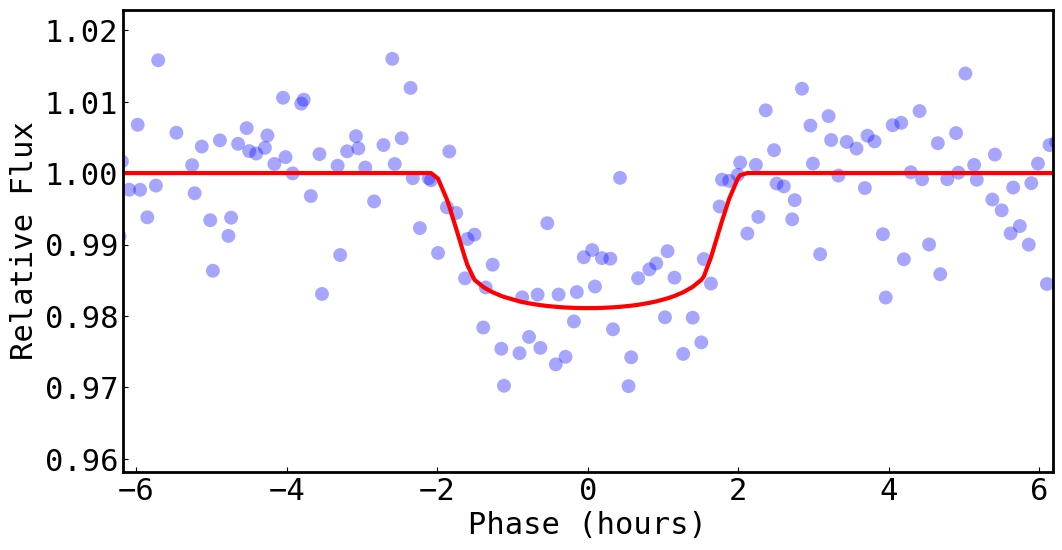

In [27]:
# Plot MCMC parameters.  Since this is based on median values and not best-fit you won't get an optimum match.
transitp.plotTransit(phot146, sol_mcmc)

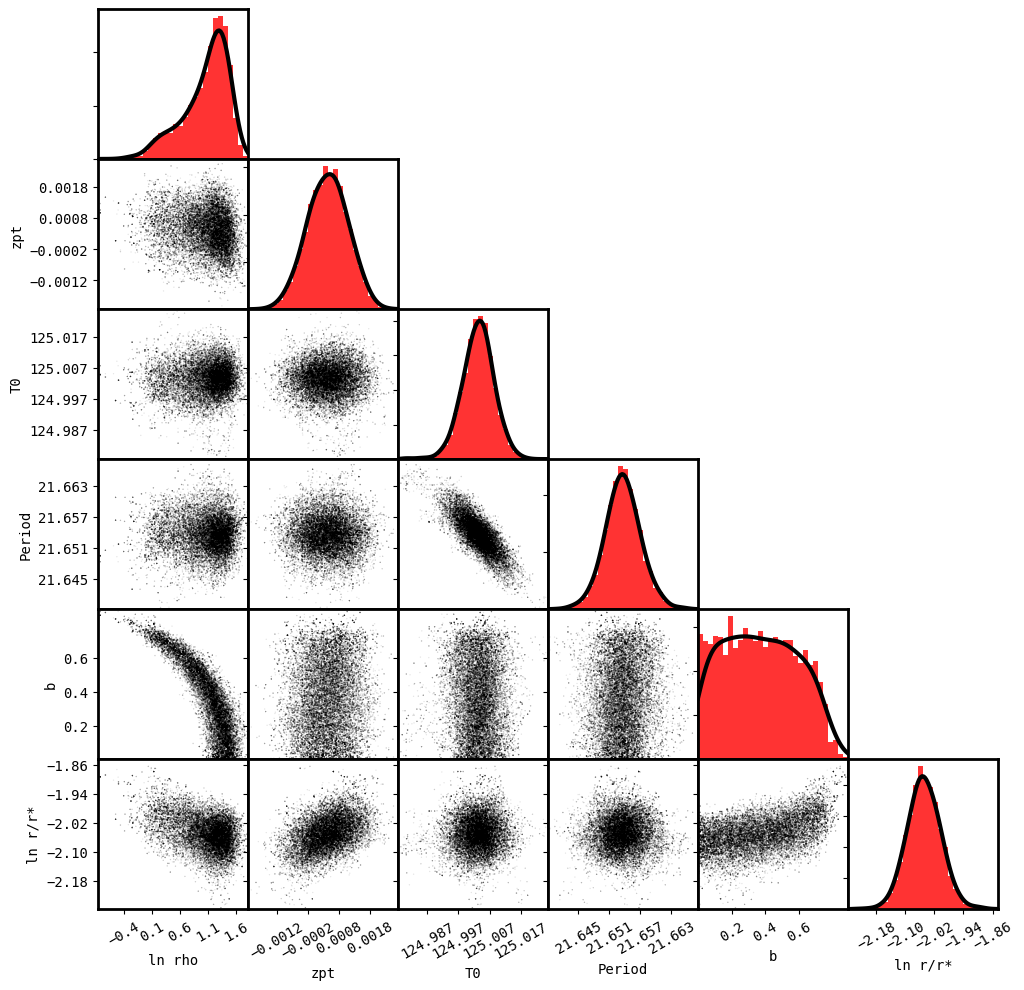

In [28]:
label = ["ln rho", "zpt", "T0", "Period", "b", "ln r/r*"]
color = ["red"]*14

plt.rcParams['font.size'] = 10
mcmc.triplot(chain, burnin, label, color, 30)

# LEO Vetting

For more information on the LEO vetter visit: https://github.com/mkunimoto/LEO-vetter

In [18]:
from leo_vetter.stellar import quadratic_ldc
from leo_vetter.main import TCELightCurve
from leo_vetter.plots import plot_modshift, plot_summary
from leo_vetter.thresholds import check_thresholds

In [19]:
# In order to use the LEO flux vetting tests assign the stellar propertis to 'star'
star = {}
star["tic"]    = tpy5_inputs.roi
star['rad']    = tpy5_inputs.rstar
star["e_rad"]  = tpy5_inputs.e_rstar
star['mass']   = tpy5_inputs.mstar
star['e_mass'] = tpy5_inputs.e_mstar        
star['rho']    = sol_fit.rho
star['e_rho']  = 0.2 * sol_fit.rho
star['Teff']   = tpy5_inputs.teff
star['e_Teff'] = tpy5_inputs.e_teff
star['logg']   = tpy5_inputs.logg
star['e_logg'] = tpy5_inputs.e_logg
star["u1"]     = 2 * np.sqrt(sol_fit.nl3) * np.sqrt(sol_fit.nl4) #Convert q1, q2 -> u1, u2
star["u2"]     = np.sqrt(sol_fit.nl3) * (1 - 2*sol_fit.nl4)

In [20]:
## Load the TCE LightCurve 

tlc = TCELightCurve(tpy5_inputs.roi, \
                    phot146.time[(phot146.icut == 0)],   phot146.flux[(phot146.icut == 0)], \
                    phot146.flux_f[(phot146.icut == 0)], phot146.ferr[(phot146.icut == 0)], \
                    sol_fit.per[0], sol_fit.t0[0], kep.transitDuration(sol_fit), planetno=1)

In [21]:
# Compute metrics 

tlc.compute_flux_metrics(star, verbose=True)

Estimating SES and MES time series...


/home/kelsey/Documents/python/Roman/Tutorials/bls_env/lib64/python3.10/site-packages/leo_vetter/utils.py:17: RuntimeWarning: invalid value encountered in scalar divide
  mean = np.sum(w * y) / np.sum(w)
/home/kelsey/Documents/python/Roman/Tutorials/bls_env/lib64/python3.10/site-packages/leo_vetter/utils.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  err = 1 / np.sqrt(np.sum(w))


Fitting linear, trapezoid, and transit models...
Running SWEET test...
Getting odd-even metrics...
Checking individual transit events...
Running modshift...
Estimating derived parameters...
Done!


In [22]:
# Check False Alarm and False Positive thresholds - Defaults set in the LEO package

FA = check_thresholds(tlc.metrics, "FA", verbose=True) # FA is True if any tests failed; False otherwise
FP = check_thresholds(tlc.metrics, "FP", verbose=True) # FP is True if any tests failed; False otherwise

if not FA and not FP:
    print(f"TRExS-{tlc.tic}.{tlc.planetno} is a planet candidate!")
            

Passed all FA tests
Passed all FP tests
TRExS-232842.1 is a planet candidate!


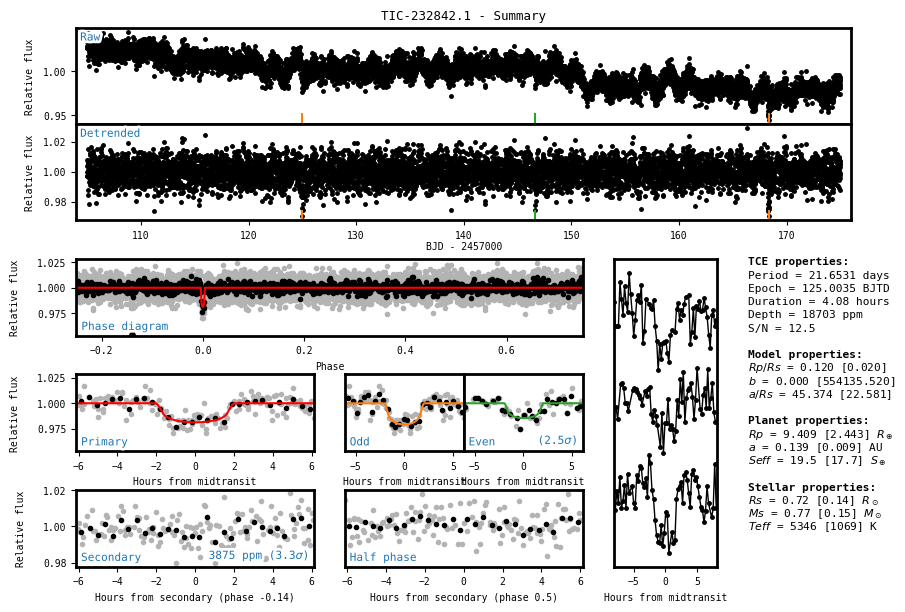

In [23]:
# View the Vetting Summary Report 

plot_summary(tlc, star, save_fig=False)
